# NLU based item search
_**Using a pretrained BERT and Elasticsearch KNN to search textually similar items**_

---

---

## Contents


1. [Background](#Background)
1. [Setup](#Setup)
1. [Lauange Translation](#Trnslate)
1. [SageMaker Model Hosting](#Hosting-Model)
1. [Build a KNN Index in Elasticsearch](#ES-KNN)
1. [Evaluate Index Search Results](#Searching-with-ES-k-NN)
1. [Extensions](#Extensions)

## Background

In this notebook, we'll build the core components of a textually similar items search. Sometime people don't know what exactly they are looking in that case they just type an item descriptions and it will retrive the similar items.

One of the core components of textually similar items search is a fixed length sentence/word embedding i,e a  “feature vectors” corrosponds to that text. The reference word/sentence embedding typically are generated offline and must be stored in. So they can be efficiently searched. So generating word/sengtence embedding can be achived by pretrained language model such as BRET(Bidirectional Encoder Representations from Transformers). In our use case we have used pretrained sentence-transformers(https://github.com/UKPLab/sentence-transformers).

To enable efficient searches for textually similar items, we'll use Amazon SageMaker to generate fixed length sentence embedding i.e “feature vectors” and use KNN algorithim in Amazon Elasticsearch service. KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance. Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

Here are the steps we'll follow to build textually similar items: After some initial setup, we'll host the pretrained BERT language model in SageMaker PyTorch model server. Then generate feature vectors for Multi-modal Corpus of Fashion Images from *__feidegger__*, a *__zalandoresearch__* dataset. Those feature vectors will be imported in Amazon Elasticsearch KNN Index. Next, we'll explore some sample text queries, and visualize the results.

## Setup

Prerequisite for this workshop:

1. **Downloading Zalando Research data**: Data originally from here: https://github.com/zalandoresearch/feidegger 

    **Citation:** <br>
 *@inproceedings{lefakis2018feidegger,* <br>
 *title={FEIDEGGER: A Multi-modal Corpus of Fashion Images and Descriptions in German},* <br>
 *author={Lefakis, Leonidas and Akbik, Alan and Vollgraf, Roland},* <br>
 *booktitle = {{LREC} 2018, 11th Language Resources and Evaluation Conference},* <br>
 *year      = {2018}* <br>
 *}*
 
1. **Create S3 bucket**: Create an Amazon S3 bucket on the same region as the SageMaker Notebook Instance. This bucket will store all the *__feidegger__* fashion dataset
1. **Setup IAM role**: Create a IAM role with *__AmazonSageMakerFullAccess__* and also create an inline policy to have *__GetObject__* & *__PutObject__* permission on the bucket
1. **Prepare the dataset**: Upload the  *__feidegger__* fashion dataset dataset in S3 bucket
1. **Create Amazon Elasticsearch domain**: Create an Amason Elasticsearch domain with version 7.1 or later
1. **Configure Amazon Elasticsearch domain**: Do the IAM role mapping in Amazon Elasticsearch using Kibana endpoint.


In [282]:
!pip install tqdm

#install necessary pkg to make connection with elasticsearch domain
!pip install elasticsearch
!pip install requests
!pip install requests-aws4auth

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [283]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

s3_resource = boto3.resource("s3")
s3 = boto3.client('s3')

In [284]:
cfn = boto3.client('cloudformation')

def get_cfn_outputs(stackname):
    outputs = {}
    for output in cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']:
        outputs[output['OutputKey']] = output['OutputValue']
    return outputs

## Setup variables to use for the rest of the demo
cloudformation_stack_name = "nlu-search"

outputs = get_cfn_outputs(cloudformation_stack_name)

bucket = outputs['s3BucketTraining']
es_host = outputs['esHostName']

outputs

ClientError: An error occurred (AccessDenied) when calling the DescribeStacks operation: User: arn:aws:sts::446913493325:assumed-role/SageMakerFullAccess/SageMaker is not authorized to perform: cloudformation:DescribeStacks on resource: arn:aws:cloudformation:us-east-1:446913493325:stack/nlu-search/*

### Downloading Zalando Research data

The dataset itself consists of 8732 high-resolution images, each depicting a dress from the available on the Zalando shop against a white-background. Each of the images has five textual annotations in German, each of which has been generated by a separate user. 

In [285]:
## Data Preparation

import os 
import shutil
import json
import tqdm
import urllib.request
from tqdm import notebook
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map

images_path = 'data/feidegger/fashion'
filename = 'metadata.json'

my_bucket = s3_resource.Bucket(bucket)

if not os.path.isdir(images_path):
    os.makedirs(images_path)

def download_metadata(url):
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        
#download metadata.json to local notebook
download_metadata('https://raw.githubusercontent.com/zalandoresearch/feidegger/master/data/FEIDEGGER_release_1.1.json')

def generate_image_list(filename):
    metadata = open(filename,'r')
    data = json.load(metadata)
    url_lst = []
    for i in range(len(data)):
        url_lst.append(data[i]['url'])
    return url_lst


def download_image(url):
    urllib.request.urlretrieve(url, images_path + '/' + url.split("/")[-1])
                    
#generate image list            
url_lst = generate_image_list(filename)     

workers = 2 * cpu_count()

#downloading images to local disk
process_map(download_image, url_lst, max_workers=workers)


In [3]:
# Uploading dataset to S3

files_to_upload = []
dirName = 'data'
for path, subdirs, files in os.walk('./' + dirName):
    path = path.replace("\\","/")
    directory_name = path.replace('./',"")
    for file in files:
        files_to_upload.append({
            "filename": os.path.join(path, file),
            "key": directory_name+'/'+file
        })
        

def upload_to_s3(file):
        my_bucket.upload_file(file['filename'], file['key'])
        
#uploading images to s3
process_map(upload_to_s3, files_to_upload, max_workers=workers)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:19: TqdmWarning: Iterable length 8792 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Lauange Translation

This dataset has product descriptions in German, So we will use Amazon Translate for English translation for each German sentence.

In [286]:
with open(filename) as json_file:
    data = json.load(json_file)

In [288]:
#Define translator function
def translate_txt(data):
    results = {}
    results['filename'] = 's3://zalando-dataset/data/feidegger/fashion/' + data['url'].split("/")[-1]
    results['descriptions'] = []
    translate = boto3.client(service_name='translate', use_ssl=True)
    for i in data['descriptions']:
        result = translate.translate_text(Text=str(i), 
            SourceLanguageCode="de", TargetLanguageCode="en")
        results['descriptions'].append(result['TranslatedText'])
    return results

In [289]:
# we are using realtime traslation which will take around ~15 min. 
workers = 8 * cpu_count()

#downloading images to local disk
results = process_map(translate_txt, data, max_workers=workers)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: TqdmWarning: Iterable length 8792 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.


In [291]:
# Saving the translated text in json format in case you need later time
with open('zalando-translated-data.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

## SageMaker Model Hosting

In this section will host the pretrained BERT model into SageMaker Pytorch model server to generte fixed length sentecce embedding from sentence-transformers. 

**Citation:** <br>
    @inproceedings{reimers-2019-sentence-bert,<br>
    title = "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks",<br>
    author = "Reimers, Nils and Gurevych, Iryna",<br>
    booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing",<br>
    month = "11",<br>
    year = "2019",<br>
    publisher = "Association for Computational Linguistics",<br>
    url = "http://arxiv.org/abs/1908.10084",<br>
}

In [138]:
#Save the model to disk which we will host at sagemaker
from sentence_transformers import models, SentenceTransformer
saved_model_dir = 'transformer'
if not os.path.isdir(saved_model_dir):
    os.makedirs(saved_model_dir)

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
model.save(saved_model_dir)

In [139]:
#Defining defalut bucket for SageMaker pretrained model hosting
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/text-based-image-search'

role = sagemaker.get_execution_role()

In [140]:
#zip the model .gz format
import tarfile
export_dir = 'transformer'
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add(export_dir, recursive=True)

In [141]:
#Upload the model to S3

inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')
inputs

's3://sagemaker-us-east-1-446913493325/model/model.tar.gz'

First we need to create a PyTorchModel object. The deploy() method on the model object creates an endpoint which serves prediction requests in real-time. If the instance_type is set to a SageMaker instance type (e.g. ml.m5.large) then the model will be deployed on SageMaker. If the instance_type parameter is set to *__local__* then it will be deployed locally as a Docker container and ready for testing locally.

First we need to create a RealTimePredictor class to accept TEXT as input and output JSON. The default behaviour is to accept a numpy array.

In [16]:
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import RealTimePredictor
from sagemaker import get_execution_role

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')
           

In [18]:
role = get_execution_role() 

pytorch_model = PyTorchModel(model_data = inputs, 
                             role=role, 
                             entry_point ='inference.py',
                             source_dir = './code', 
                             framework_version = '1.3.1',
                             predictor_cls=StringPredictor)

predictor = pytorch_model.deploy(instance_type='ml.m5.large', initial_instance_count=3)


---------------!

sentence transformer uses BERT pretrained model so it will generate 768 dimension for the given text. we will quickly validate the same in next cell.

In [292]:
# Doing a quick test to make sure model is generating the embeddings
import json
payload = 'Denim Dress'
features = predictor.predict(payload)
embading = json.loads(features)

embading


[0.18807634711265564,
 -1.214261770248413,
 -0.5946414470672607,
 -0.8647702932357788,
 0.5200745463371277,
 1.050364375114441,
 0.22016049921512604,
 0.3115285038948059,
 -0.33151859045028687,
 -0.42110875248908997,
 0.5028215646743774,
 0.6665668487548828,
 0.3208930790424347,
 0.29663074016571045,
 -0.7473700046539307,
 0.1666591316461563,
 0.019141271710395813,
 0.5534024834632874,
 -0.11269643902778625,
 -0.4020542502403259,
 0.13484978675842285,
 0.8564456105232239,
 -0.2788946330547333,
 0.9314526319503784,
 -0.8044163584709167,
 -0.9129719734191895,
 0.20826253294944763,
 -0.3430066704750061,
 0.6582567691802979,
 0.5881334543228149,
 -0.26635026931762695,
 0.042556971311569214,
 0.7152447700500488,
 0.3413059115409851,
 -0.29263055324554443,
 -0.9422176480293274,
 0.007102726027369499,
 -0.27762195467948914,
 0.4810880422592163,
 -0.40534693002700806,
 -0.9343820810317993,
 -0.11849816143512726,
 0.39915090799331665,
 0.3745388388633728,
 0.406005322933197,
 -1.111448049545288

## Build a KNN Index in Elasticsearch

KNN for Amazon Elasticsearch Service lets you search for points in a vector space and find the "nearest neighbors" for those points by Euclidean distance. Use cases include recommendations (for example, an "other songs you might like" feature in a music application), image recognition, and fraud detection.

KNN requires Elasticsearch 7.1 or later. Full documentation for the Elasticsearch feature, including descriptions of settings and statistics, is available in the Open Distro for Elasticsearch documentation. For background information about the k-nearest neighbors algorithm

In this step we'll get all the translated product descriptions of *__zalandoresearch__* dataset and import those embadings into Elastichseach 7.4 domain.

In [143]:
#install necessary pkg to make connection with elasticsearch domain
! pip install elasticsearch
! pip install requests
! pip install requests-aws4auth

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [214]:
# setting up the Elasticsearch connection
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
region = 'us-east-1' # e.g. us-east-1
service = 'es'
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(credentials.access_key, credentials.secret_key, region, service, session_token=credentials.token)

es = Elasticsearch(
    hosts = [{'host': es_host, 'port': 443}],
    http_auth = awsauth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)

In [166]:
#KNN index maping
knn_index = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
           "zalando_nlu_vector": {
                "type": "knn_vector",
                "dimension": 768
            } 
        }
    }
}

In [221]:
#Creating the Elasticsearch index
es.indices.create(index="idx_zalando",body=knn_index,ignore=400)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'idx_zalando'}

In [293]:
results[0]['descriptions']

['Short, sexy, summer, sexy, party, yellow dress, and sleeveless',
 'a yellow dress that has a length up to about the knees and has a v neckline. The dress has an off-the-shoulder accent',
 'Knee-length fabric dress in yellow with wide skirt, off the shoulder with deep round neckline.',
 'Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than the front.',
 'Airy summer dress that is slightly longer at the back. It is sleeveless, has a V-neck and wide straps.']

In [296]:
#Concating all the product description into a single scentence, 
#so that we will have a one embeddings for each product

def concat_desc(results):
    obj = {
        'filename': results['filename'],
    }
    obj['descriptions'] = ' '.join(results['descriptions'])
    return obj

concat_results = map(concat_desc, results)
concat_results = list(concat_results)
concat_results[0]

{'filename': 's3://zalando-dataset/data/feidegger/fashion/Y0321C00U-E11@10.jpg',
 'descriptions': 'Short, sexy, summer, sexy, party, yellow dress, and sleeveless a yellow dress that has a length up to about the knees and has a v neckline. The dress has an off-the-shoulder accent Knee-length fabric dress in yellow with wide skirt, off the shoulder with deep round neckline. Yellow sleeveless summer dress. It has a slightly rounded V-neck. The dress is longer at the back than the front. Airy summer dress that is slightly longer at the back. It is sleeveless, has a V-neck and wide straps.'}

In [227]:

# defining a function to import the feature vectors corrosponds to each S3 URI into Elasticsearch KNN index
# This process will take around ~10 min.

def es_import(concat_results):
    vector = json.loads(predictor.predict(concat_results['descriptions']))
    es.index(index='idx_zalando',
             body={"zalando_nlu_vector": vector,
                   "image": concat_results['filename']}
            )
        
workers = 8 * cpu_count()
    
process_map(es_import, concat_results, max_workers=workers)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:14: TqdmWarning: Iterable length 8792 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Evaluate Index Search Results

In this step we will use SageMaker SDK as well as Boto3 SDK to query the Elasticsearch to retrive the nearest neighbours and retrive the relevent product images from Amazon S3 to display in the notebook.

In [297]:
#define display_image function
from PIL import Image
import io
def display_image(bucket, key):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket)
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    img = Image.open(file_stream)
    return display(img)

###### SageMaker SDK Method

In [298]:
#SageMaker SDK approach
import json
payload = 'half sleves'
features = predictor.predict(payload)
embading = json.loads(features)

In [ ]:
#ES index search
import json
k = 3
idx_name = 'idx_zalando'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'zalando_nlu_vector': {'vector': embading, 'k': k}}}})


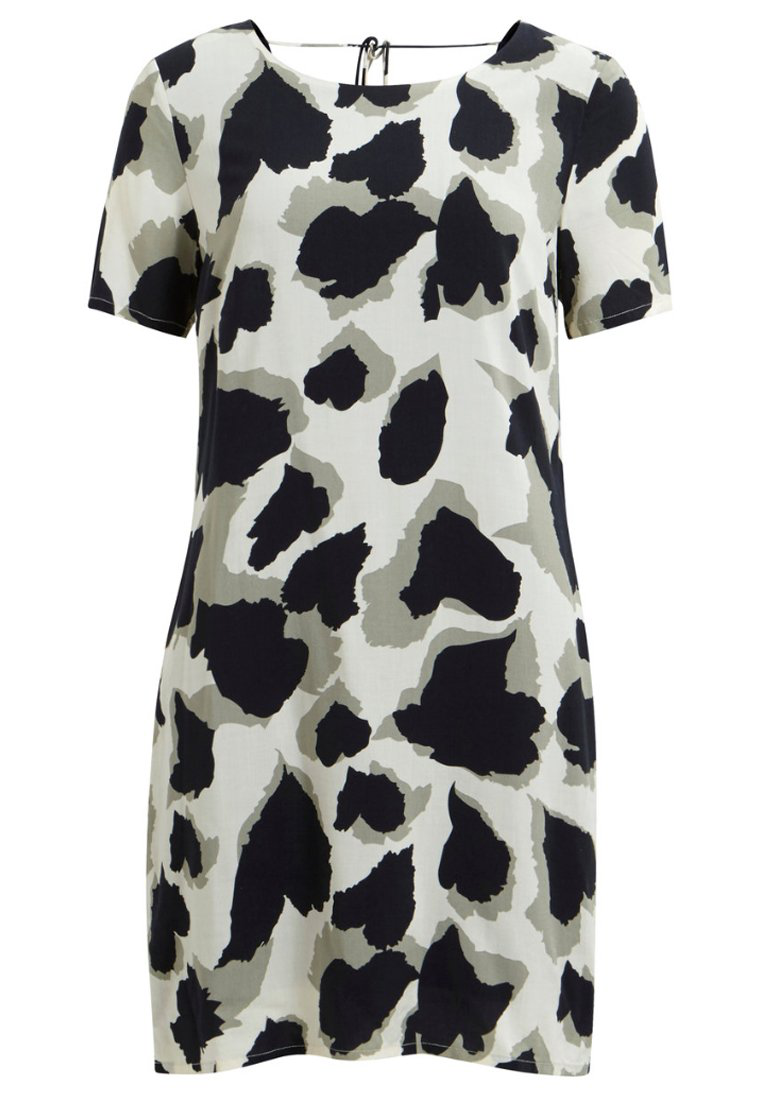

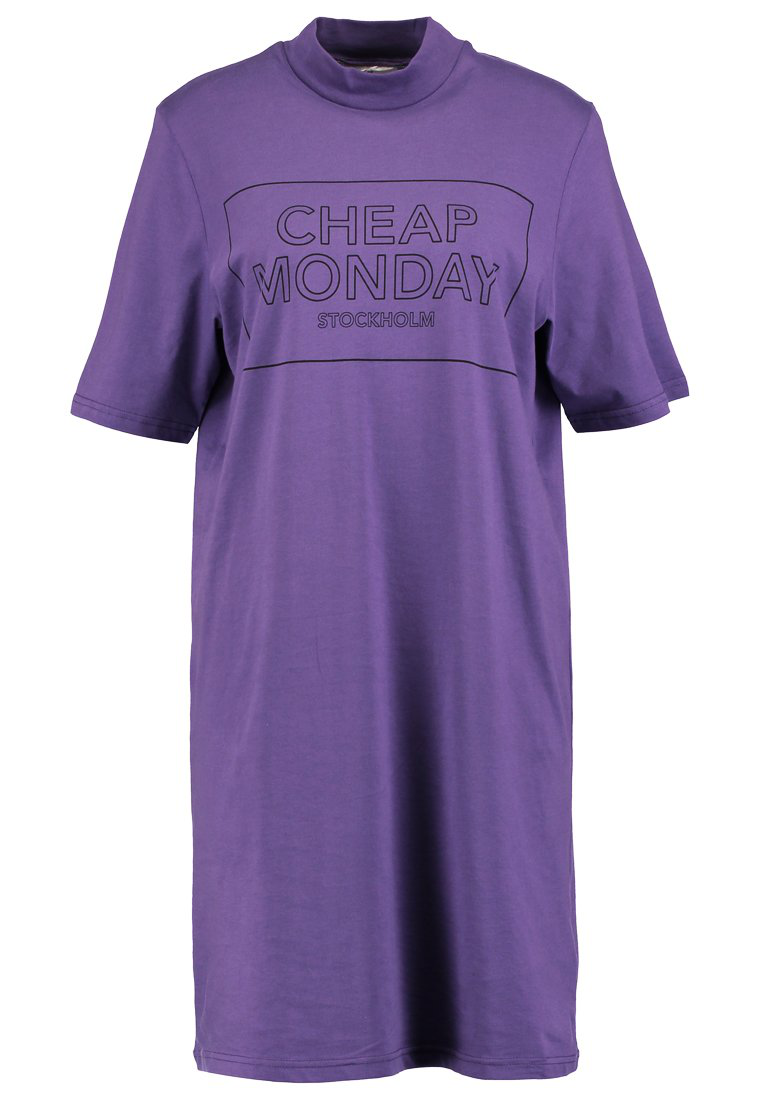

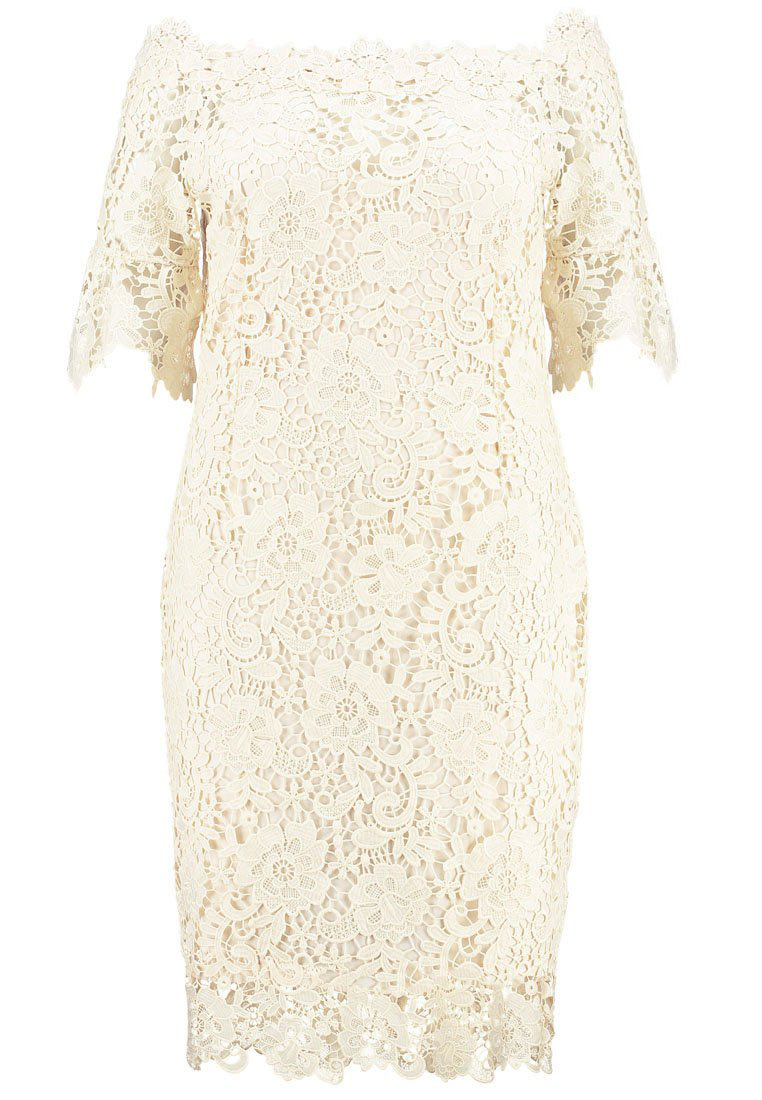

In [268]:
#Display the image
bucket = 'zalando-dataset' # <Define your own bucket>

for x in res['hits']['hits']:
    key = x['_source']['image']
    key = key.replace('s3://zalando-dataset/','')
    img = display_image(bucket,key)

## Boto3 Method

In [84]:
#calling SageMaker Endpoint
client = boto3.client('sagemaker-runtime')
payload = 'denim dress'
ENDPOINT_NAME = 'pytorch-inference-2020-06-10-21-27-19-006' # <ENTER THE SAGEMAKER ENDPOINT NAME>
response = client.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                       ContentType='text/plain',
                                       Body=payload)

response_body = json.loads((response['Body'].read()))


In [85]:
#ES index search
import json
k = 3
idx_name = 'idx_zalando'
res = es.search(request_timeout=30, index=idx_name,
                body={'size': k, 
                      'query': {'knn': {'zalando_nlu_vector': {'vector': response_body, 'k': k}}}})

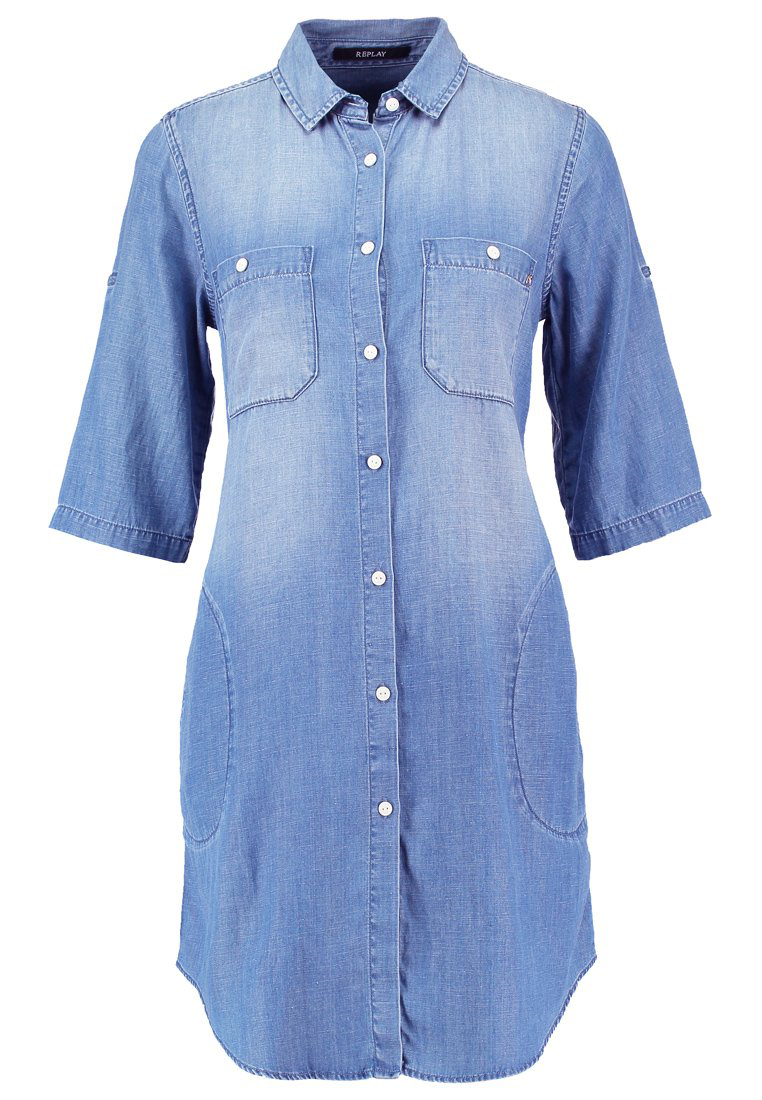

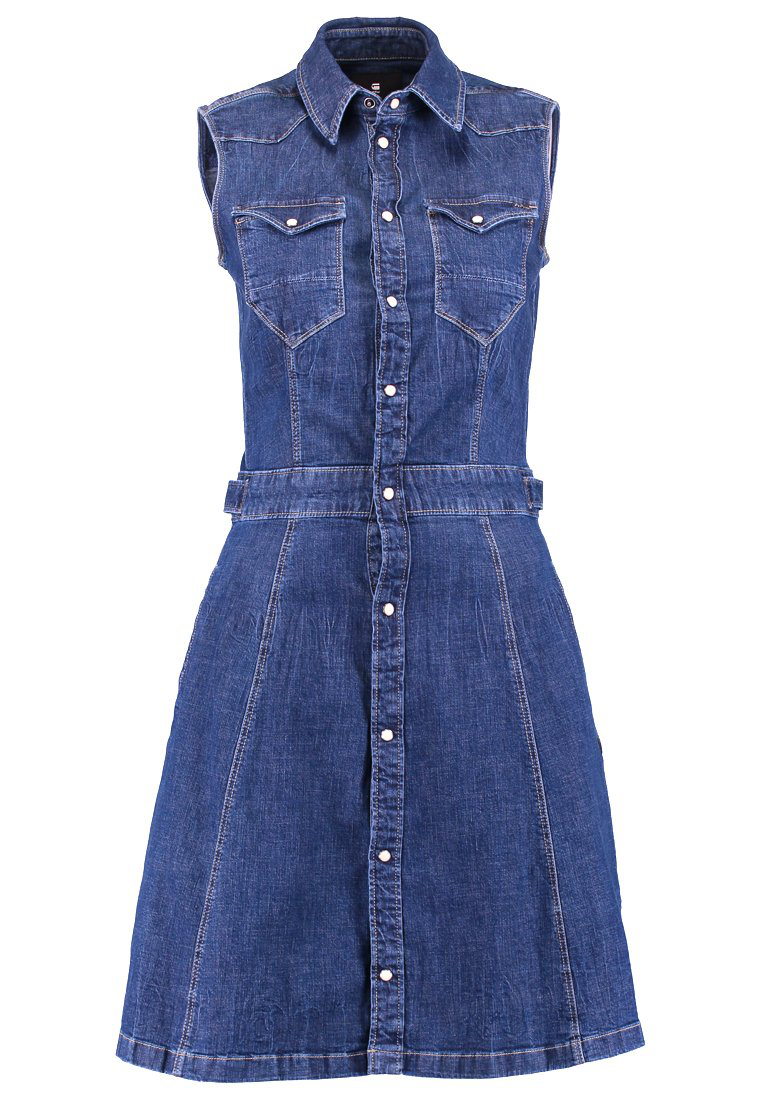

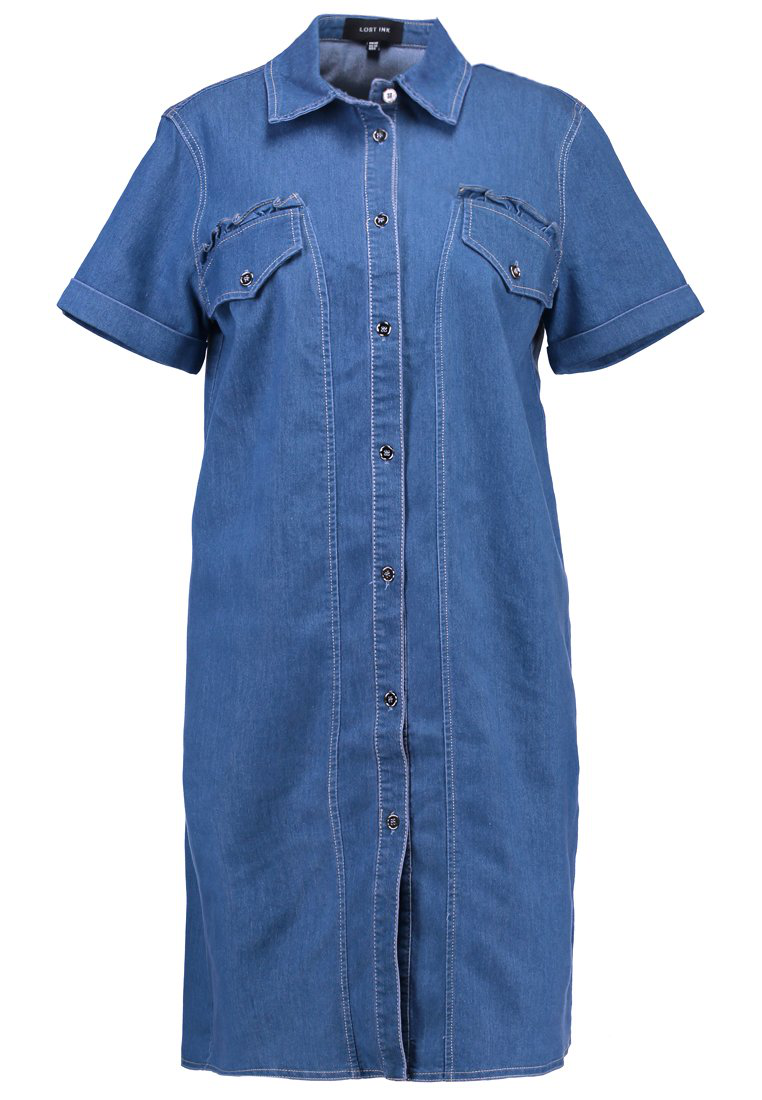

In [86]:
#Display the image
bucket = 'zalando-dataset'

for i in range(k):
    key = res['hits']['hits'][i]['_source']['image']
    key = key.replace('s3://zalando-dataset/','')
    img = display_image (bucket,key)

## Deploying a full-stack visual search application

In [ ]:
s3_resource.Object(bucket, 'backend/template.yaml').upload_file('./backend/template.yaml', ExtraArgs={'ACL':'public-read'})


sam_template_url = f'https://{bucket}.s3.amazonaws.com/backend/template.yaml'

# Generate the CloudFormation Quick Create Link

print("Click the URL below to create the backend API for visual search:\n")
print((
    'https://console.aws.amazon.com/cloudformation/home?region=us-east-1#/stacks/create/review'
    f'?templateURL={sam_template_url}'
    '&stackName=vis-search-api'
    f'&param_BucketName={outputs["s3BucketTraining"]}'
    f'&param_DomainName={outputs["esDomainName"]}'
    f'&param_ElasticSearchURL={outputs["esHostName"]}'
    f'&param_SagemakerEndpoint={predictor.endpoint}'
))

Now that you have a working Amazon SageMaker endpoint for extracting image features and a KNN index on Elasticsearch, you are ready to build a real-world full-stack ML-powered web app. The SAM template you just created will deploy an Amazon API Gateway and AWS Lambda function. The Lambda function runs your code in response to HTTP requests that are sent to the API Gateway.

In [ ]:
# Review the content of the Lambda function code.
!pygmentize backend/lambda/app.py

## Once the CloudFormation Stack shows CREATE_COMPLETE, proceed to this cell below:

In [ ]:
import json
api_endpoint = get_cfn_outputs('vis-search-api')['ImageSimilarityApi']

with open('./frontend/src/config/config.json', 'w') as outfile:
    json.dump({'apiEndpoint': api_endpoint}, outfile)

## Step 2: Deploy frontend services

In [ ]:
%cd ./frontend/

!npm install

In [ ]:
!npm run-script build

In [ ]:
hosting_bucket = f"s3://{outputs['s3BucketHostingBucketName']}"

!aws s3 sync ./build/ $hosting_bucket --acl public-read

In [ ]:
print('Click the URL below:\n')
print(outputs['S3BucketSecureURL'] + '/index.html')

You should see the following page:

## Step 3: Browse your frontend service

## Extensions

We have used pretrained BERT model from sentence-transformers.Now if you have domain specific problem then you need to tune the sentence-transformers model with your own data. For detail implementaion of fine tuning please check https://github.com/UKPLab/sentence-transformers.


### Cleanup

Make sure that you stop the notebook instance, delete the Amazon SageMaker endpoint and delete the Elasticsearch domain to prevent any additional charges.